# Emotion Classification with Keras Embedding & LSTM

Collection of documents and its emotions, It helps greatly in NLP Classification tasks

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


In [1]:
import zipfile
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
# Keras Embedding Layer => which can convert word indices into fixed-size vectors and 
# It is a layer that learns these vectors during model training. We use it when learning vectors from scracth.
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.decomposition import PCA

## Data Understanding

In [2]:
train_df = pd.read_csv('../emotion_dataset/train.txt', sep=';', header=None, names=['text', 'label'])
val_df = pd.read_csv('../emotion_dataset/val.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('../emotion_dataset/test.txt', sep=';', header=None, names=['text', 'label'])

In [3]:
train_df.shape, val_df.shape, test_df.shape

((16000, 2), (2000, 2), (2000, 2))

In [4]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
                                                text    label
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can have for a treat or if i am feeling festive      joy
                                                text    label
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i lef

In [5]:
print(train_df["label"].value_counts()/len(train_df)*100)
print(val_df["label"].value_counts()/len(val_df)*100)
print(test_df["label"].value_counts()/len(test_df)*100)

label
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64
label
joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: count, dtype: float64
label
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: count, dtype: float64


## Text Preprocessing

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # punctuations
    text = text.lower()  # lower case
    text = re.sub(r'\d+', '', text)  # numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # space
    
    return text

train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
label_to_int = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

# To subject the labels to numerical coding process
train_df['label'] = train_df['label'].map(label_to_int)
val_df['label'] = val_df['label'].map(label_to_int)
test_df['label'] = test_df['label'].map(label_to_int)

In [8]:
train_df.head()

,text,label
0,didnt feel humiliated,1
1,go feeling hopeless damned hopeful around some...,1
2,im grabbing minute post feel greedy wrong,2
3,ever feeling nostalgic fireplace know still pr...,4
4,feeling grouchy,2


## Tokenizer and Text Sequence

***NOTE: We first tokenize the text and then convert it to numeric strings.***

text = "Bu bir örnek cümledir."

tokens = ["Bu", "bir", "örnek", "cümledir"]

"Bu" -> 1

"bir" -> 2

"örnek" -> 3

"cümledir" -> 4

sequence = [1, 2, 3, 4]

In [9]:
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(train_df['text'])

# We obtain numerical arrays in which each word will be converted to the corresponding index.
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_val = tokenizer.texts_to_sequences(val_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

## Pad Sequences

**NOT**: ***It is the process of converting text data into fixed-length strings. Because neural networks such as LSTM require fixed-size inputs.***

X_train = [[1, 2, 3], [4, 5, 6, 7, 8], [9]]

max_len = 5

**X_train = pad_sequences( X_train , maxlen=max_len )**

X_train = [ [0, 0, 1, 2, 3],  
    [4, 5, 6, 7, 8],       
    [0, 0, 0, 0, 9] ]

In [10]:
max_len = 100

X_train = pad_sequences(X_train, maxlen=max_len)

X_val = pad_sequences(X_val, maxlen=max_len)

X_test = pad_sequences(X_test, maxlen=max_len)

In [11]:
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

## Modeling with Keras Word Embedding

In [12]:
model = Sequential([
        # Generally,there is an input layer in here! Word vectors obtained by embedding model are actually input 
        # when you look at it from the general perspective!
        Embedding(input_dim = max_words,
                  input_length = max_len,
                  output_dim = 128, 
                  # It is the size of the word vectors to be created. For small-to-medium sized data sets, 50-100 is good.
                  # In large data sets there may be around 200-300.
                  name='embedding_layer'),

        LSTM(128),
        BatchNormalization(),
        Dropout(0.2),
        Dense(6, activation='softmax') # We have a 6-class assessment!

    ])


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    verbose=1,
                    callbacks=early_stopping
                    )

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 191ms/step - accuracy: 0.5920 - loss: 1.1031 - val_accuracy: 0.2475 - val_loss: 2.8358
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 103s 205ms/step - accuracy: 0.9346 - loss: 0.2004 - val_accuracy: 0.8010 - val_loss: 0.7113
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 201ms/step - accuracy: 0.9636 - loss: 0.1137 - val_accuracy: 0.8260 - val_loss: 0.6505
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 216ms/step - accuracy: 0.9717 - loss: 0.0833 - val_accuracy: 0.8790 - val_loss: 0.5245
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 211ms/step - accuracy: 0.9802 - loss: 0.0619 - val_accuracy: 0.8780 - val_loss: 0.5801
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 263ms/step - accuracy: 0.9806 - loss: 0.0612 - val_accuracy: 0.8980 - val_loss: 0.3912
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 290ms/step - accuracy: 0.9864 - loss: 0.0405 - val_accuracy: 0.8955 - val_loss: 0.4082
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 191s 267ms/step - accuracy: 

In [14]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Val Loss: {val_loss}", f"Val Accuracy: {val_accuracy}")
print(f"Test Loss: {test_loss}", f"Test Accuracy: {test_accuracy}")

Val Loss: 0.35846152901649475 Val Accuracy: 0.9075000286102295
Test Loss: 0.34437456727027893 Test Accuracy: 0.9110000133514404


In [15]:
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=-1)

# Since I am looking at a multi-class classification problem, I have used classification_report() from sckit-learn.
classification_rep = classification_report(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)

print(accuracy)
print(classification_rep)

0.911
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       695
           1       0.96      0.96      0.96       581
           2       0.90      0.89      0.89       275
           3       0.90      0.85      0.88       224
           4       0.78      0.86      0.81       159
           5       0.74      0.74      0.74        66

    accuracy                           0.91      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.91      0.91      0.91      2000



## Embedding Layer



In [16]:
embedding_layer = model.get_layer(name='embedding_layer') # weights => values inside vectors

embedding_weights = embedding_layer.get_weights()[0]

In [17]:
embedding_weights

array([[ 0.00509012,  0.00645083,  0.00965891, ..., -0.0147312 ,
         0.03164802, -0.039795  ],
       [ 0.12822172, -0.1360196 ,  0.0318299 , ..., -0.05096995,
         0.03797638, -0.01924566],
       [ 0.09586438, -0.15878005,  0.04717446, ..., -0.07055388,
         0.03975945, -0.00574626],
       ...,
       [-0.00899236,  0.07592741,  0.04563675, ..., -0.06304795,
        -0.03329554, -0.08839434],
       [ 0.01511195, -0.06387065,  0.01466976, ...,  0.03951296,
         0.04158199, -0.04335005],
       [-0.01799539, -0.02193938,  0.00791544, ..., -0.02056956,
        -0.00045715, -0.00692855]], dtype=float32)

## Words Indexes

In [18]:
word_index = tokenizer.word_index

index_word = {v: k for k, v in word_index.items()}

In [19]:
list(index_word.items())[:10]

[(1, 'feel'),
 (2, 'feeling'),
 (3, 'like'),
 (4, 'im'),
 (5, 'really'),
 (6, 'know'),
 (7, 'time'),
 (8, 'get'),
 (9, 'little'),
 (10, 'people')]

## Using Embedding Vectors

In [20]:
happy_index = word_index.get('happy')

sad_index = word_index.get('sad')

happy_vector = embedding_weights[happy_index]

sad_vector = embedding_weights[sad_index]

print("Happy Vector:", happy_vector)
print("Sad Vector:", sad_vector)

Happy Vector: [ 0.01502542  0.01308896 -0.03137678  0.04781587  0.12549205 -0.00498338
  0.01403974 -0.03503389 -0.03766701  0.08887212 -0.00361274 -0.02725565
 -0.00476486 -0.03893864 -0.02242909  0.09342957  0.0472286  -0.04374623
 -0.08583993  0.08652239 -0.03791697  0.06426546 -0.05667351 -0.06655788
 -0.03325607  0.00660251  0.02062783 -0.02823501 -0.0009028   0.02948332
 -0.10989982  0.02516647  0.01967268 -0.03253066 -0.02651012  0.0270205
  0.08391277  0.02665527 -0.01496008 -0.01358142  0.05680982  0.01895444
  0.0842661  -0.04558004 -0.00599144 -0.02375961 -0.05276715 -0.09260708
 -0.06025164  0.01197226  0.08178033  0.01150922 -0.09684546  0.09748704
 -0.01731844  0.00389525 -0.02873352 -0.02144876 -0.0205433   0.01591757
  0.019845   -0.02551387  0.0328689  -0.03247184  0.10222469 -0.03829229
 -0.03491259  0.03880961  0.05033183 -0.01537441 -0.04967163  0.02794728
  0.0201407  -0.05437861 -0.10576534 -0.0275606  -0.09347469  0.0559136
 -0.02969094  0.06934304 -0.05737823  0

In [21]:
len(happy_vector)

128

## Find Closest Embeddings

In [22]:
def find_closest_embeddings(embedding, word_embedding):
    
    cosine_similarities = cosine_similarity(embedding, word_embedding.reshape(1, -1))
    return np.argsort(cosine_similarities.flatten())[::-1]

closest_to_happy = find_closest_embeddings(embedding_weights, happy_vector)

for idx in closest_to_happy[:5]:
    print(index_word[idx])

happy
mellow
peaceful
innocent
convinced


In [23]:
closest_to_sad = find_closest_embeddings(embedding_weights, sad_vector)

for idx in closest_to_sad[:5]:
    print(index_word[idx])

sad
emotional
rotten
hopeless
embarrassed


## Arithmetic Operations with Vectors

In [24]:
result_vector = happy_vector - sad_vector

closest_to_result = find_closest_embeddings(embedding_weights, result_vector)

for idx in closest_to_result[:5]:
    print(index_word[idx])

convinced
duno
knock
satisfied
amused


In [26]:
angry_index = word_index.get('angry')
angry_vector = embedding_weights[angry_index]

result_vector = happy_vector - sad_vector + angry_vector

closest_to_result = find_closest_embeddings(embedding_weights, result_vector)

for idx in closest_to_result[:5]:
    print(index_word[idx])

angry
morbid
poetry
mall
designing


## 2D Visualization of Emotion Vectors

In [27]:
emotions = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise', 'happy', 'sad', 'angry', 'fear', 'disgust']

emotion_vectors = {emotion: embedding_weights[word_index[emotion]] for emotion in emotions}

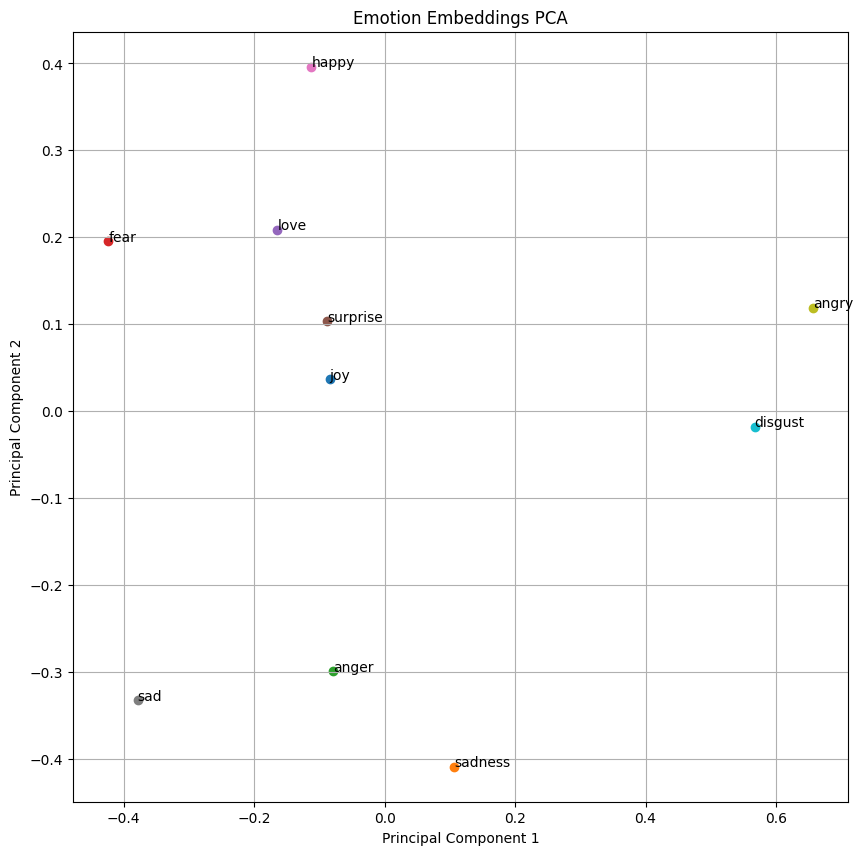

In [28]:
def plot_emotions(emotion_vectors):
    
    vectors = list(emotion_vectors.values())
    labels = list(emotion_vectors.keys())

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    
    for i, label in enumerate(labels):
        plt.scatter(pca_result[i, 0], pca_result[i, 1])
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]))
        
    plt.title('Emotion Embeddings PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


plot_emotions(emotion_vectors)